In [1]:
# define imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import collections
import os
import pickle

C:\Users\a0393451\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of car images:8792
Number of non-car images:8968
Data-type for car images:uint8
Data-type for non-car images:uint8
Shape for car image :(64, 64, 3)
Shape for non-car image :(64, 64, 3)


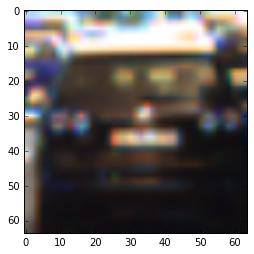

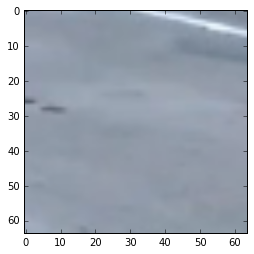

In [2]:
# function to get some stats on the dataset
cars = []
notcars = []
images_car = glob.glob('.\\TrainingData\\vehicles\\vehicles\\*\\*.png')
images_noncar = glob.glob('.\\TrainingData\\non-vehicles\\non-vehicles\\*\\*.png')
print("Number of car images:{}".format(len(images_car)))
print("Number of non-car images:{}".format(len(images_noncar)))
# read an image and find the data type (NOTE: CV2 reads .png images on 0 to 255 scale)
test_carimage = cv2.imread(images_car[0])
test_noncarimage = cv2.imread(images_noncar[0])
print("Data-type for car images:{}".format(test_carimage.dtype))
print("Data-type for non-car images:{}".format(test_noncarimage.dtype))
print("Shape for car image :{}".format(test_carimage.shape))
print("Shape for non-car image :{}".format(test_noncarimage.shape))
# plot a random sample from car and non-car images
ind = np.random.choice(len(images_car))
plot_image = cv2.imread(images_car[ind])
plt.figure(figsize=(4,4))
plt.imshow(plot_image)
plt.show()

ind = np.random.choice(len(images_noncar))
plot_image = cv2.imread(images_noncar[ind])
plt.figure(figsize=(4,4))
plt.imshow(plot_image)
plt.show()

In [2]:
# define a class which has all the methods to extract features
class extract_features:
    def __init__(self):
        self.debug = False
        self.test_list = [] # store the outcome of all operations done on an image, for debug purposes
        # parameters for computing HOG features
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.orient = 9
     
    def convert_colorspace(self, img, color_space='BGR'):
        '''
        To convert the color space
        '''
        if color_space != 'BGR':
            if color_space == 'HSV':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            elif color_space == 'RGB':
                op_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        else: op_image = np.copy(img)
        
        if self.debug:
            self.test_list.append(op_image)
        
        return op_image
            
    def bin_spatial(self, img, size=(64,64)):
        '''
        Performs re-sizing, and vectorizes the image as spatial features
        
        '''
        # do resizing to desired size
        feature_image_resize = cv2.resize(img,size)
        features = feature_image_resize.ravel() 
        if self.debug:
            self.test_list.append(feature_image_resize)
        return features
    
    def computeHOG_features(self, img, vis=False, feature_vec=True):
        '''
        Compute the HOG feature for the image, image is single channel image
        '''
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_feat  = []
        hog_image_list = []
       
        if vis == True:
            # Use skimage.hog() to get both features and a visualization
            features,  hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                   cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
            
            if self.debug:
                print("Shape of HOG features:{}".format(features.shape))
                self.test_list.append(hog_image) 
            return features, hog_image
        else:      
            # Use skimage.hog() to get features only
            features =hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                          cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
                
            if self.debug:
                print("Shape of HOG features:{}".format(features.shape))
            return features, []
        
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the RGB channels separately
        rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        if self.debug:
            self.test_list.append(rhist[0])
            self.test_list.append(ghist[0])
            self.test_list.append(bhist[0])
            
        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features

Shape of HOG features:(7, 7, 2, 2, 9)
Shape of HOG features:(7, 7, 2, 2, 9)
Shape of HOG features:(7, 7, 2, 2, 9)


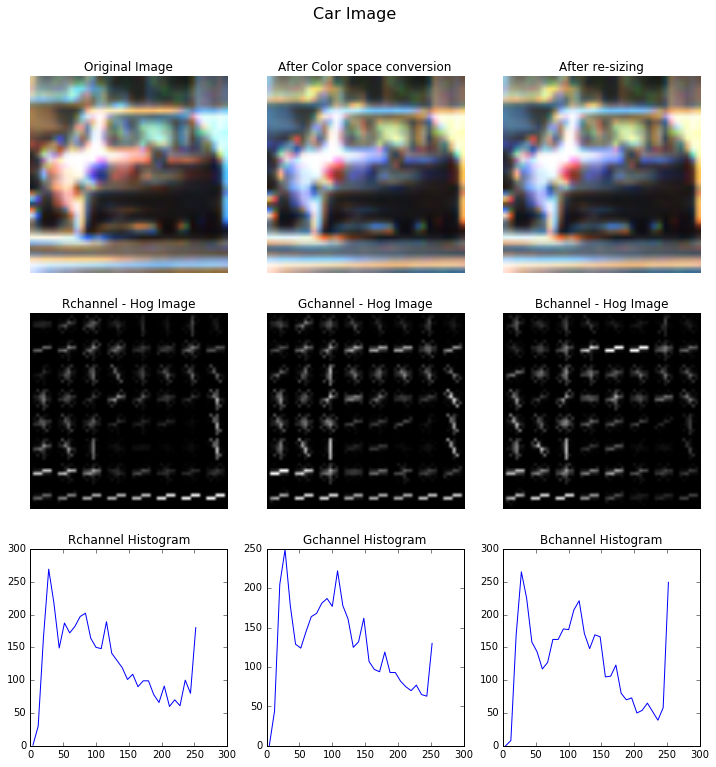

Shape of HOG features:(7, 7, 2, 2, 9)
Shape of HOG features:(7, 7, 2, 2, 9)
Shape of HOG features:(7, 7, 2, 2, 9)


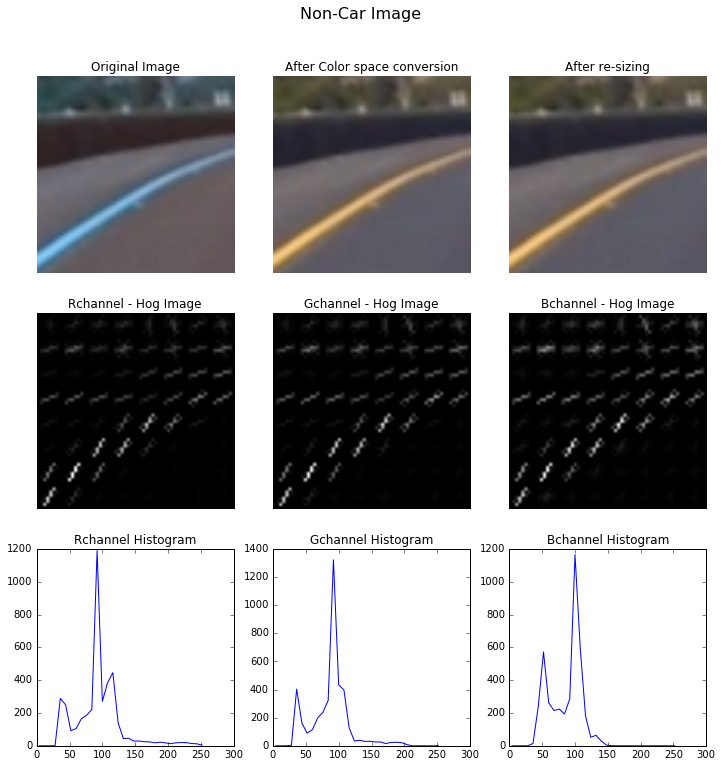

In [4]:
# Plot the feature set for the car and non-car image
def plot_features(image_list, title):
    '''
    Helper function: This function just plots all the possible feature set for the desired image (only for illustration)
    Inputs: list of car and non-car image paths
    '''
    ext_feature = extract_features()
    # turn on the debug mode
    ext_feature.debug = True
    # read a car and a non-car image
    ind = np.random.choice(len(image_list))
    test_img = cv2.imread(image_list[ind])
    
    # convert color space to RGB
    img = ext_feature.convert_colorspace(test_img, color_space='RGB')
    
    # compute the feature set for car images
    _ = ext_feature.bin_spatial(img, size=(64,64))
    
    # convert image to grayscale for computing HOG features
    #test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    feature_ch1, hog_image_ch1 = ext_feature.computeHOG_features(img[:,:,0], vis=True, feature_vec=True)
    feature_ch2, hog_image_ch2 = ext_feature.computeHOG_features(img[:,:,1], vis=True, feature_vec=True)
    feature_ch3, hog_image_ch3 = ext_feature.computeHOG_features(img[:,:,2], vis=True, feature_vec=True)
    _,_,_,bin_centers,_ = ext_feature.color_hist(img, nbins=32, bins_range=(0, 256))
    
    # plot the original image/ changed color space/ HOG feature/ Color Histogram
    gs = GridSpec(2, 4, hspace=0.2, wspace=0.2)
    plt.figure(figsize=(12,12))
    for i in range(7):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
    
    #fig.subplots_adjust(wspace=0, hspace=4)
    plt.subplot(3,3,1)
    plt.imshow(test_img)
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(3,3,2)
    plt.imshow(ext_feature.test_list[0])
    plt.axis('off')
    plt.title("After Color space conversion")
    plt.subplot(3,3,3)
    plt.imshow(ext_feature.test_list[1])
    plt.axis('off')
    plt.title("After re-sizing")
    # plot HOG Images
    plt.subplot(3,3,4)
    plt.imshow(ext_feature.test_list[2], cmap='gray')
    plt.axis('off')
    plt.title("Rchannel - Hog Image")
    plt.subplot(3,3,5)
    plt.imshow(ext_feature.test_list[3], cmap='gray')
    plt.axis('off')
    plt.title("Gchannel - Hog Image")
    plt.subplot(3,3,6)
    plt.imshow(ext_feature.test_list[4], cmap='gray')
    plt.axis('off')
    plt.title("Bchannel - Hog Image")
    # Plot the RGB Histograms
    plt.subplot(3,3,7)
    plt.plot(bin_centers,ext_feature.test_list[5])
    plt.title("Rchannel Histogram")
    plt.subplot(3,3,8)
    plt.plot(bin_centers,ext_feature.test_list[6])
    plt.title("Gchannel Histogram")
    plt.subplot(3,3,9)
    plt.plot(bin_centers,ext_feature.test_list[7])
    plt.title("Bchannel Histogram")
    plt.suptitle(title, fontsize=16)
    plt.show()

# plot features for car image    
plot_features(images_car, title="Car Image")
# plot features for noncar image
plot_features(images_noncar, title="Non-Car Image")

In [11]:
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32
extract_feat = extract_features() # class object
# helper function to compute feature on a single image
def compute_singleimg_feature(img, extract_feat, spatialsize=(64,64), colorspace = 'BGR', visualization=False, \
                     featvec=True, nhistbins= 32, binsrange=(0,256)):
    
    # convert color space to RGB
    image = extract_feat.convert_colorspace(img, color_space=colorspace)
    
    # compute spatial binning
    bin_spat_feat = extract_feat.bin_spatial(image, size=spatialsize)
    # compute HOG
    #image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    HOG_feat_ch1, _ = extract_feat.computeHOG_features(image[:,:,0], vis=visualization, feature_vec=featvec)
    HOG_feat_ch2, _ = extract_feat.computeHOG_features(image[:,:,1], vis=visualization, feature_vec=featvec)
    HOG_feat_ch3, _ = extract_feat.computeHOG_features(image[:,:,2], vis=visualization, feature_vec=featvec)
    
    # Color Hist 
    _,_,_,_,Color_Hist = extract_feat.color_hist(image, nbins=nhistbins, bins_range=binsrange)
    # combine all the features 
    return np.concatenate((bin_spat_feat, HOG_feat_ch1, HOG_feat_ch2, HOG_feat_ch3, Color_Hist))
    
    
# construct the feature set for all images
def computefeatureset(imgfileslist, extract_feat, spatialsize=(64,64), colorspace = 'BGR', visualization=False, \
                     featvec=True, nhistbins= 32, binsrange=(0,256)):
    '''
    This function computes the features for all the files in imagefileslist, need to pass an object of class extract_features
    '''
    features = []
    for img in imgfileslist:
        image = cv2.imread(img)
        # call function to compute feature on single image
        feat = compute_singleimg_feature(image, extract_feat, spatialsize=spatialsize, colorspace = colorspace, \
                                    visualization=visualization, featvec=featvec, nhistbins= nhistbins, binsrange=binsrange)
        # combine all the features 
        features.append(feat)
        
    return features
        
 

In [ ]:
car_features    = computefeatureset(images_car, extract_feat, spatialsize=spatial_size, colorspace=color_space, \
                                    nhistbins=hist_bins)
noncar_features = computefeatureset(images_noncar, extract_feat, spatialsize=spatial_size, colorspace=color_space, \
                                   nhistbins=hist_bins)
   

In [6]:
# construct a classifier
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(noncar_features))))
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])

Test Accuracy of SVC =  0.981981981982
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]


In [10]:
# picle the svm
pickle_file = 'classifier.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('classifier.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'svm': svc,
                    'scalar': X_scaler,
            
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [7]:
# load the pickle file
pickle_file = 'classifier.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  svc = pickle_data['svm']
  X_scaler = pickle_data['scalar']
  del pickle_data  # Free up memory


print('Data and modules loaded.')
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32
extract_feat = extract_features() # class object

Data and modules loaded.


In [8]:
# functions to do sliding window on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
#                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
#window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
#plt.imshow(window_img)

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, extract_feat, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, \
                    hist_range=(0, 256), vis=False, feature_vec=True):
    '''
    img          : image
    windows      : list of windows
    extract_feat : object of class extract_features
    clf          : classifier object
    scaler       : features scaling object
    '''

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], spatial_size)      
        #4) Extract features for that window using single_img_features()
        features = compute_singleimg_feature(test_img, extract_feat, spatialsize=spatial_size, colorspace = color_space, \
                                             visualization=vis, featvec=feature_vec, nhistbins= hist_bins, binsrange=hist_range)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

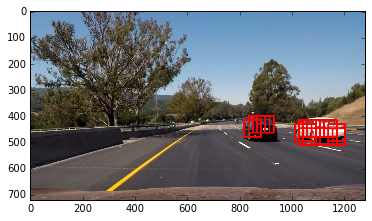

In [12]:
# perform classification over a test image
# read images in the test image folder
image_list = glob.glob('.\\test_images\\*.jpg')
test_img = cv2.imread(image_list[5])
draw_image = np.copy(test_img)
x_start_stop = [0, test_img.shape[1]]
y_start_stop = [400, 700]
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32
windows = slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, \
                    xy_window=spatial_size, xy_overlap=(0.75, 0.75))

hot_windows = search_windows(test_img, windows, extract_feat, svc, X_scaler, color_space=color_space, \
                        spatial_size=spatial_size, hist_bins=hist_bins)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    

b,g,r = cv2.split(window_img)
window_img_rgb = cv2.merge((r,g,b))
plt.figure()
plt.imshow(window_img_rgb)
plt.show()

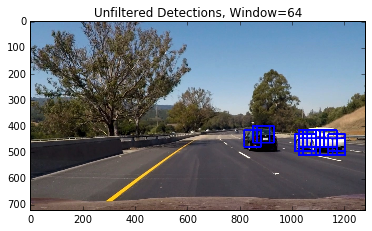

2 cars found


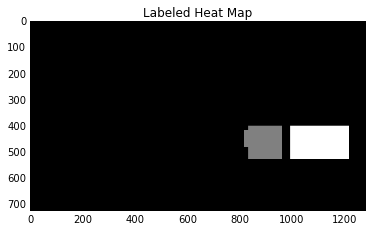

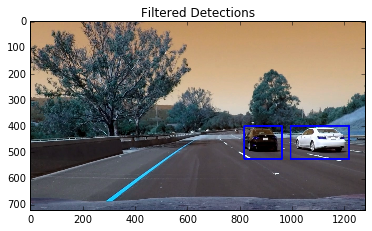

In [35]:
extract_feat = extract_features() # class object
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, colorspace):
    
    pix_per_cell   = extract_feat.pix_per_cell
    cell_per_block = extract_feat.cell_per_block
    orient         = extract_feat.orient
    bbox_list      = []
    
    # convert the color space before computing HOG
    img = extract_feat.convert_colorspace(img, color_space=colorspace)
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    #image_gray = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2GRAY)
    #hog1 = extract_feat.computeHOG_features(image_gray, vis=False, feature_vec=False)
        
    hog1, _ = extract_feat.computeHOG_features(ch1, vis=False, feature_vec=False)
    hog2, _ = extract_feat.computeHOG_features(ch2, vis=False, feature_vec=False)
    hog3, _ = extract_feat.computeHOG_features(ch3, vis=False, feature_vec=False)
    
    #print(hog1)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], spatial_size)
            
            
            # Get color features
            bin_spat_feat = extract_feat.bin_spatial(subimg, size=spatial_size)
            # Color Hist 
            _,_,_,_,Color_Hist = extract_feat.color_hist(subimg, nbins=hist_bins, bins_range=(0,256))
            
            # concatenate all the features
            combined_features = np.concatenate((bin_spat_feat, hog_features, Color_Hist))
            # scale the features
            test_features = X_scaler.transform(np.array(combined_features).reshape(1, -1))
            # make prediction   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list
    

# read images in the test image folder
image_list = glob.glob('.\\test_images\\*.jpg')
test_img = cv2.imread(image_list[5])
x_start_stop = [0, test_img.shape[1]]
y_start_stop = [400, 680]
scale        = 1
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32

ystart, ystop = y_start_stop[0], y_start_stop[1]
# scale set to 1
scale = 1
out_img1, bbox_list1 = find_cars(test_img, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
# scale set to 2
scale = 2
out_img2, bbox_list2 = find_cars(test_img, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
# scale set to 4
scale = 4
out_img3, bbox_list3 = find_cars(test_img, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)

bbox_list = bbox_list1 + bbox_list2 + bbox_list3

plt.figure()
plt.imshow(out_img1)
plt.title("Unfiltered Detections, Window=64")
plt.show()

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Iterate once more to add more heat to the car bounding box
    for box in bbox_list:
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# label heatmap
labels = label(heatmap)

print(labels[1], 'cars found')

plt.figure()
plt.imshow(labels[0], cmap='gray')
plt.title("Labeled Heat Map")
plt.show()

img = draw_labeled_bboxes(test_img, labels)
plt.figure()
plt.imshow(img)
plt.title("Filtered Detections")
plt.show()

In [43]:
x_start_stop = [0, test_img.shape[1]]
y_start_stop = [400, 680]
scale        = 1
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32
ystart, ystop = y_start_stop[0], y_start_stop[1]
count        = 0
count_thresh = 5
frame_no = 0
heatlist = collections.deque(maxlen = 5)
dump_frames = True

def process_frames(img):
    global frame_no
    
    frame_no += 1
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #if frame_no==1:
    #    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #else:
    #    heat = np.mean(heatlist, axis=0)
    
    # video gives RGB channels, change to BGR space
    r,g,b = cv2.split(img)
    img_bgr   = cv2.merge((b,g,r))
    scale = 1
    _, bbox_list1 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    scale = 2
    _, bbox_list2 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    scale = 4
    _, bbox_list3 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    bbox_list = bbox_list1 + bbox_list2 + bbox_list3
    # Add heat to each box in box list
    #print(heat)
    heatadd = add_heat(heat,bbox_list)
    heatlist.append(heatadd)
   
    avgheat = np.mean(heatlist, axis=0)
    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(avgheat,4)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresh, 0, 255)
    # label heatmap
    labels = label(heatmap)
    img_op = draw_labeled_bboxes(img, labels)
    if frame_no==-10:
        print(heatmap)
        print(labels[0])
        plt.figure()
        plt.imshow(labels[0], cmap='gray')
        plt.title("Labeled Heat Map")
        plt.show()
        
        plt.figure()
        plt.imshow(heatmap)
        plt.title("Heat Map")
        plt.show()
    
    #print(frame_no, np.max(avgheat.ravel()))
    if dump_frames:
        fname1 = './video_frames/'+ "frameno"+ str(frame_no) + 'HeatThresholded.jpg'
        fname2 = './video_frames/'+ "frameno"+ str(frame_no) + 'Label.jpg'
        fname3 = './video_frames/'+ "frameno"+ str(frame_no) + 'Img.jpg'
        plt.imsave(fname1, heatmap)
        plt.imsave(fname2, labels[0])
        plt.imsave(fname3, img_op)
                
    return img_op
    
# process the video
#####################################
# Run our pipeline on the test video 
#####################################
clip = VideoFileClip("./test_video.mp4")
output_video = "./test_video_processed_3.mp4"
output_clip = clip.fl_image(process_frames)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./test_video_processed_3.mp4
[MoviePy] Writing video ./test_video_processed_3.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:10<00:01,  1.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_processed_3.mp4 



In [38]:
x_start_stop = [0, test_img.shape[1]]
y_start_stop = [400, 680]
scale        = 1
color_space  = 'RGB'
spatial_size = (64, 64)
hist_bins    = 32
ystart, ystop = y_start_stop[0], y_start_stop[1]
count        = 0
count_thresh = 5
frame_no = 0
heatlist = collections.deque(maxlen = 5)
dump_frames = False

def process_frames(img):
    global frame_no
    
    frame_no += 1
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #if frame_no==1:
    #    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #else:
    #    heat = np.mean(heatlist, axis=0)
    
    # video gives RGB channels, change to BGR space
    r,g,b = cv2.split(img)
    img_bgr   = cv2.merge((b,g,r))
    scale = 1
    _, bbox_list1 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    scale = 2
    _, bbox_list2 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    scale = 4
    _, bbox_list3 = find_cars(img_bgr, ystart, ystop, scale, extract_feat, svc, X_scaler, spatial_size, hist_bins, color_space)
    bbox_list = bbox_list1 + bbox_list2 + bbox_list3
    # Add heat to each box in box list
    #print(heat)
    heatadd = add_heat(heat,bbox_list)
    heatlist.append(heatadd)
   
    avgheat = np.mean(heatlist, axis=0)
    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(avgheat,4)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresh, 0, 255)
    # label heatmap
    labels = label(heatmap)
    img_op = draw_labeled_bboxes(img, labels)
    
    #print(frame_no, np.max(avgheat.ravel()))
    if dump_frames:
        fname1 = './video_frames/'+ "frameno"+ str(frame_no) + '.jpg'
        cv2.imwrite(fname1, img_op)
                
    return img_op
    
# process the video
#####################################
# Run our pipeline on the test video 
#####################################
clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_processed_2.mp4"
output_clip = clip.fl_image(process_frames)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_processed_2.mp4
[MoviePy] Writing video ./project_video_processed_2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [39:02<00:01,  1.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_processed_2.mp4 

